In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import os


2024-11-16 00:15:33.470991: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 00:15:33.523966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 00:15:34.359006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def c6_data():
    df = pd.read_csv('Fill-1.csv')
    print(df.shape)

    # 删除重复值
    df.drop_duplicates(inplace=True)
    print(df.shape)

    x = df.iloc[:, :2].values
    y = df.iloc[:, 2].values

    print(x.shape, y.shape)
    
    # 归一化
    scaler_x = StandardScaler()
    scaler_x.fit(x)
    x = scaler_x.transform(x)

    scaler_y = StandardScaler()
    y = y.reshape(-1, 1)  # Reshape y to have one feature
    scaler_y.fit(y)
    y = scaler_y.transform(y)

    # 划分数据集
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=666)

    return x_train, x_test, y_train, y_test, scaler_x, scaler_y

# 获取数据
x_train, x_test, y_train, y_test, scaler_x, scaler_y = c6_data()

# 保存处理后的数据在csv文件里
def save_data_to_csv(x_train, x_test, y_train, y_test):
    # 将数据转换为DataFrame
    df_x_train = pd.DataFrame(x_train)
    df_x_test = pd.DataFrame(x_test)
    df_y_train = pd.DataFrame(y_train)
    df_y_test = pd.DataFrame(y_test)

    # 保存到CSV文件
    df_x_train.to_csv('x_train_tl.csv', index=False)
    df_x_test.to_csv('x_test_tl.csv', index=False)
    df_y_train.to_csv('y_train_tl.csv', index=False)
    df_y_test.to_csv('y_test_tl.csv', index=False)

save_data_to_csv(x_train, x_test, y_train, y_test)


(169544, 3)
(135550, 3)
(135550, 2) (135550,)


In [3]:
# 假设每个样本有10个时间步长
sequence_length = 10

# 生成时间序列数据
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# 创建训练和测试序列
x_train_seq = create_sequences(x_train, sequence_length)
x_test_seq = create_sequences(x_test, sequence_length)

# 调整 y_train 和 y_test 的形状以匹配序列
y_train_seq = y_train[sequence_length - 1:]
y_test_seq = y_test[sequence_length - 1:]

# 归一化数据
scaler = StandardScaler()

# 展平 x_train_seq 进行归一化
num_samples, sequence_length, num_features = x_train_seq.shape
x_train_flat = x_train_seq.reshape(-1, num_features)
x_train_scaled = scaler.fit_transform(x_train_flat).reshape(num_samples, sequence_length, num_features)

# 展平 x_test_seq 进行归一化
num_samples_test = x_test_seq.shape[0]
x_test_flat = x_test_seq.reshape(-1, num_features)
x_test_scaled = scaler.transform(x_test_flat).reshape(num_samples_test, sequence_length, num_features)


In [4]:
# 定义 LSTM 模型
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features), return_sequences=True))  # LSTM 层
model.add(LSTM(32))  # 额外的 LSTM 层
model.add(Dense(1))  # 输出层

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

model_path = './lstmmodel/model_lstm_weight'
# 加载模型
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("Model loaded from disk.")
else:
    print("Model file not found.")


2024-11-16 00:15:44.075184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 658 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


Model loaded from disk.


In [5]:
# Freeze the first LSTM layer
model.layers[0].trainable = False


In [6]:
# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])


In [8]:
# Fine-tune the model with new data
history = model.fit(x_train_scaled, y_train_seq, epochs=50, batch_size=200, validation_data=(x_test_scaled, y_test_seq))


Epoch 1/50


2024-10-29 06:13:58.864989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-29 06:13:58.951881: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd0a0768880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-29 06:13:58.951903: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-29 06:13:58.956374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 18/543 [..............................] - ETA: 1s - loss: 1.2235 - mae: 0.9325   

2024-10-29 06:13:59.085382: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


543/543 [==============================] - 5s 5ms/step - loss: 0.9110 - mae: 0.7919 - val_loss: 0.6915 - val_mae: 0.6896
Epoch 2/50
543/543 [==============================] - 2s 3ms/step - loss: 0.4812 - mae: 0.5765 - val_loss: 0.3072 - val_mae: 0.4564
Epoch 3/50
543/543 [==============================] - 2s 3ms/step - loss: 0.2583 - mae: 0.4039 - val_loss: 0.2374 - val_mae: 0.3764
Epoch 4/50
543/543 [==============================] - 2s 3ms/step - loss: 0.2161 - mae: 0.3516 - val_loss: 0.2080 - val_mae: 0.3384
Epoch 5/50
543/543 [==============================] - 2s 3ms/step - loss: 0.1915 - mae: 0.3209 - val_loss: 0.1862 - val_mae: 0.3131
Epoch 6/50
543/543 [==============================] - 2s 3ms/step - loss: 0.1724 - mae: 0.2997 - val_loss: 0.1691 - val_mae: 0.2943
Epoch 7/50
543/543 [==============================] - 2s 3ms/step - loss: 0.1579 - mae: 0.2837 - val_loss: 0.1565 - val_mae: 0.2808
Epoch 8/50
543/543 [==============================] - 2s 3ms/step - loss: 0.1471 - mae:

In [8]:
# 预测并计算额外的指标
y_pred = model.predict(x_test_scaled)

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test_seq, y_pred)
print(f"MSE: {mse}")

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# 计算平均绝对误差 (MAE)
mae = mean_absolute_error(y_test_seq, y_pred)
print(f"MAE: {mae}")

# 计算 R²
r2 = r2_score(y_test_seq, y_pred)
print(f"R²: {r2}")


101/847 [==>...........................] - ETA: 1s

2024-11-16 00:15:59.181911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


847/847 [==============================] - 2s 2ms/step
MSE: 0.06920077973992383
RMSE: 0.26306041081835907
MAE: 0.1605391482800232
R²: 0.9315231401006044


In [45]:
model.save('lstmtlmodel.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
# 保存迁移学习后的模型
fine_tuned_model_path = './lstmtlmodel/model_lstmlt_weight_TL'
model.save(fine_tuned_model_path)
print("Fine-tuned model saved to disk.")


INFO:tensorflow:Assets written to: ./lstmtlmodel/model_lstmlt_weight_TL/assets


INFO:tensorflow:Assets written to: ./lstmtlmodel/model_lstmlt_weight_TL/assets


Fine-tuned model saved to disk.


In [7]:
# 加载迁移学习后的模型
fine_tuned_model_path = './lstmtlmodel/model_lstmlt_weight_TL'
if os.path.exists(fine_tuned_model_path):
    model = tf.keras.models.load_model(fine_tuned_model_path)
    print("Fine-tuned model loaded from disk.")
else:
    print("Model file not found.")
    

Fine-tuned model loaded from disk.


损失图已保存到: tl_lstm_fig/lstm_loss_plot.png
局部放大损失图已保存到: tl_lstm_fig/zoom_loss_plot.png


/tmp/ipykernel_834/1398553602.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


结合图已保存到: tl_lstm_fig/lstm_combined_plot.png


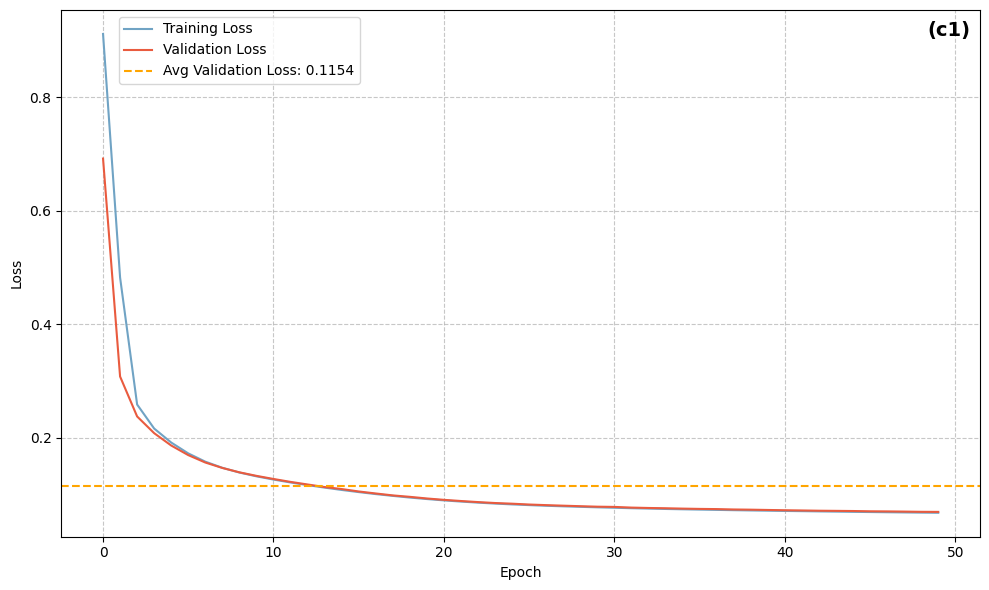

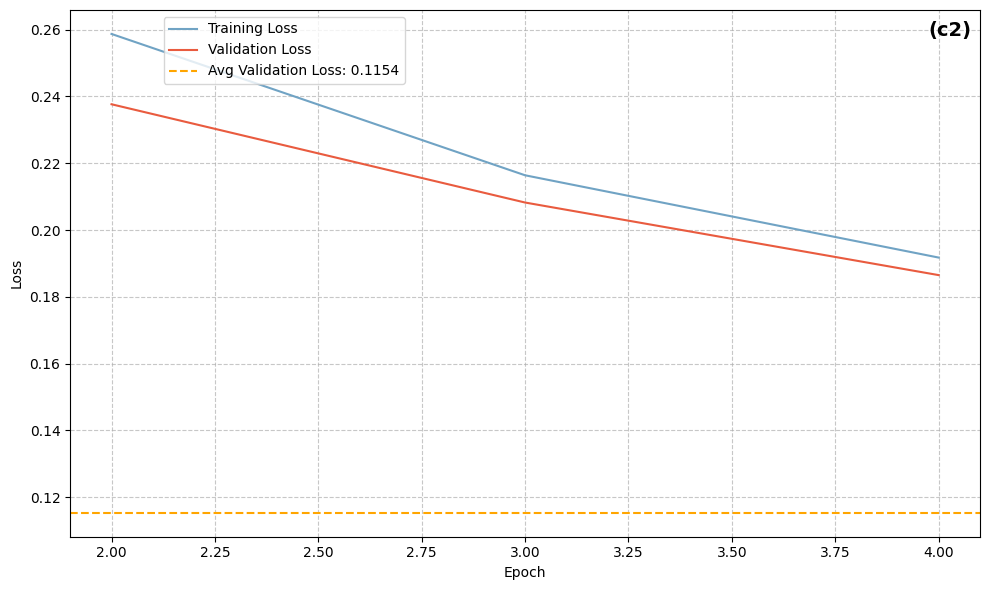

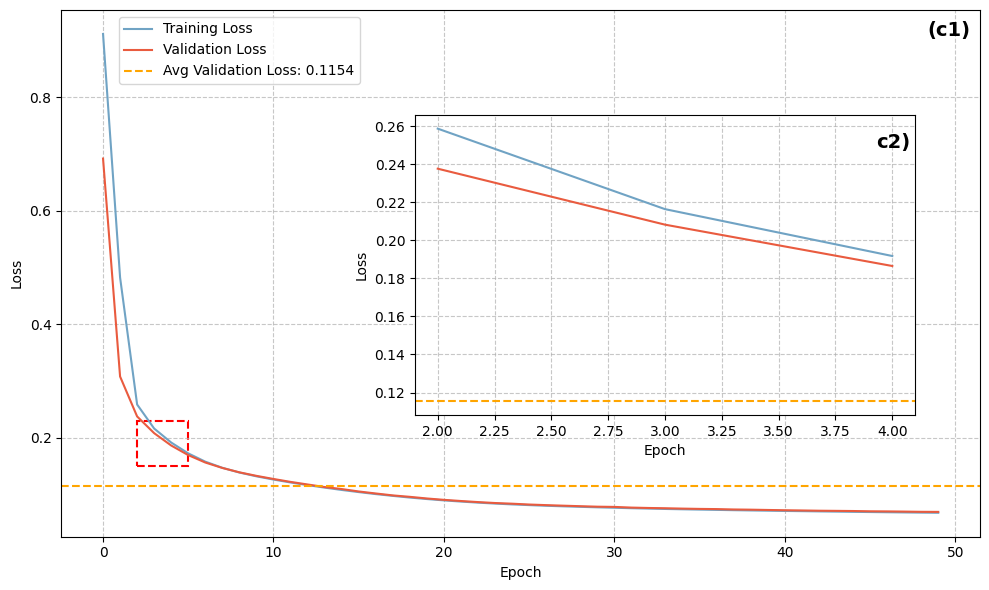

In [13]:
# 假设 train_loss_list 和 val_loss_list 是 LSTM 模型的训练和验证损失
train_loss_list = history.history['loss']
val_loss_list = history.history['val_loss']

# 计算平均验证损失
avg_val_loss = np.mean(val_loss_list)

# 自定义缩放范围
zoom_epoch_start = 2
zoom_epoch_end = 5

# 自定义矩形高度
rect_y_min = 0.15
rect_y_max = 0.23

# 创建保存图像的文件夹
folder_name = "tl_lstm_fig"
os.makedirs(folder_name, exist_ok=True)

# 绘制损失图
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss_list, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss_list, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(c1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
loss_file_path = os.path.join(folder_name, 'lstm_loss_plot.png')
plt.savefig(loss_file_path, dpi=300, bbox_inches='tight')
print(f"损失图已保存到: {loss_file_path}")

# 绘制局部放大图
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss_list[zoom_epoch_start:zoom_epoch_end], color='#70A3C4', label='Training Loss')
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss_list[zoom_epoch_start:zoom_epoch_end], color='#E95B3F', label='Validation Loss')
ax2.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax2.legend(loc='upper left', bbox_to_anchor=(0.095, 1), bbox_transform=ax2.transAxes)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.99, 0.98, '(c2)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
zoom_loss_file_path = os.path.join(folder_name, 'zoom_loss_plot.png')
plt.savefig(zoom_loss_file_path, dpi=300, bbox_inches='tight')
print(f"局部放大损失图已保存到: {zoom_loss_file_path}")

# 绘制结合图，将局部放大图嵌入到主图中
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss_list, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss_list, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(c1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 嵌入放大损失图
inset_ax = fig.add_axes([0.42, 0.30, 0.5, 0.5])  # [left, bottom, width, height]
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss_list[zoom_epoch_start:zoom_epoch_end], color='#70A3C4')
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss_list[zoom_epoch_start:zoom_epoch_end], color='#E95B3F')
inset_ax.axhline(y=avg_val_loss, color='#FFA500', linestyle='--')  # 添加平均值线
inset_ax.set_xlabel('Epoch')
inset_ax.set_ylabel('Loss')
inset_ax.grid(True, linestyle='--', alpha=0.7)
inset_ax.text(0.99, 0.94, 'c2)', transform=inset_ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 添加红色虚线框
rect = plt.Rectangle((zoom_epoch_start, rect_y_min), 
                     zoom_epoch_end - zoom_epoch_start, 
                     rect_y_max - rect_y_min, 
                     edgecolor='red', linestyle='--', linewidth=1.5, facecolor='none', transform=ax1.transData)
ax1.add_patch(rect)

plt.tight_layout()
combined_file_path = os.path.join(folder_name, 'lstm_combined_plot.png')
plt.savefig(combined_file_path, dpi=300, bbox_inches='tight')
print(f"结合图已保存到: {combined_file_path}")

# 显示图表
plt.show()

825/825 [==============================] - 1s 2ms/step


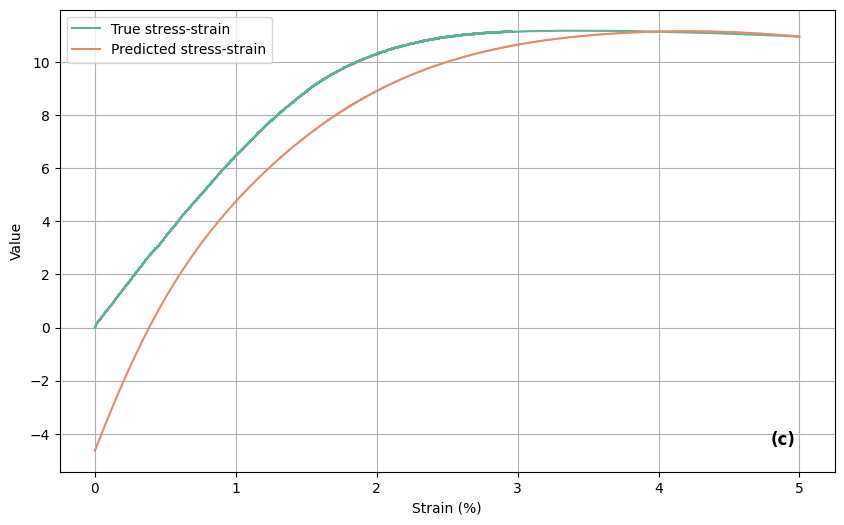

预测曲线与实际曲线已保存并显示: tl_lstm_fig/prediction/predicted_vs_true_curve.png


In [9]:
# 读取新数据
file_name = '60-p.csv'
df_new_data = pd.read_csv(file_name)

# 提取特征和真实值
x_new = df_new_data.iloc[:, :2].values  # 假设前两列是特征
y_true = df_new_data.iloc[:, 2].values  # 第三列为真实值
strain = df_new_data.iloc[:, 1].values  # 假设第二列是应变值

# 归一化特征
x_new_scaled = scaler_x.transform(x_new)

# 创建时间序列数据
sequence_length = 10
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

x_new_seq = create_sequences(x_new_scaled, sequence_length)

# 进行预测
y_pred_scaled = model.predict(x_new_seq)

# 将预测值逆归一化
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# 确保预测值和实际值的长度相同
min_length = min(len(y_true), len(y_pred))
y_true_truncated = y_true[sequence_length - 1:sequence_length - 1 + min_length]
y_pred_truncated = y_pred[:min_length]
strain_truncated = strain[sequence_length - 1:sequence_length - 1 + min_length]

# 截断到应变小于或等于2.7
valid_indices = strain_truncated <= 5
strain_truncated = strain_truncated[valid_indices]
y_true_truncated = y_true_truncated[valid_indices]
y_pred_truncated = y_pred_truncated[valid_indices]

# 绘制预测结果与真实值的对比图
plt.figure(figsize=(10, 6))
plt.plot(strain_truncated, y_true_truncated, label='True stress-strain', color='#62B197')
plt.plot(strain_truncated, y_pred_truncated, label='Predicted stress-strain', color='#E18E6D')
plt.xlabel('Strain (%)')
plt.ylabel('Value')
plt.legend()
# plt.title('True vs Predicted Values')
plt.grid(True)

# 在右下角添加文本 (b1)
plt.text(0.95, 0.05, '(c)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='bottom')


# 保存图像
folder_path = os.path.join('tl_lstm_fig', 'prediction')
os.makedirs(folder_path, exist_ok=True)
save_path = os.path.join(folder_path, 'predicted_vs_true_curve.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"预测曲线与实际曲线已保存并显示: {save_path}")


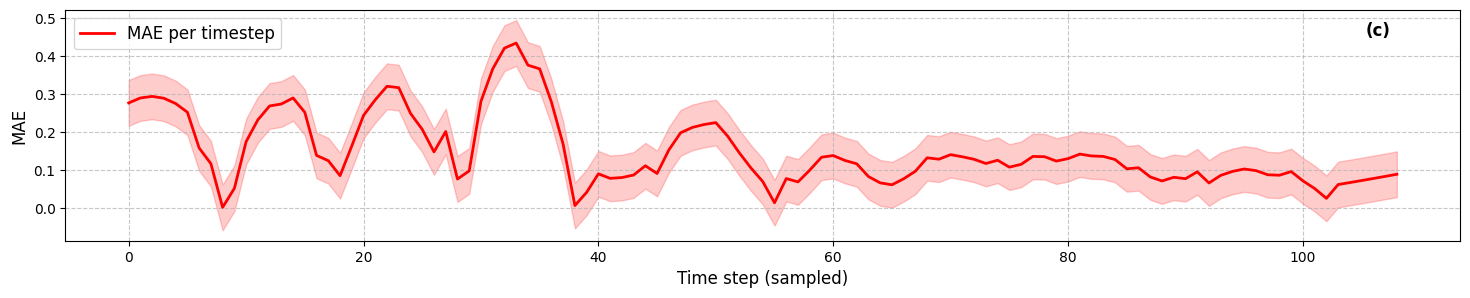

MAE per timestep plot saved and displayed: ./tl_lstm_fig/mae_per_timestep.png


In [10]:
from scipy.signal import savgol_filter

# 计算每个时间步的 MAE
mae_per_timestep = np.abs(y_test_seq - y_pred).mean(axis=1)

# 采样数据以减少密度（例如，每隔250个点取一个）
sampling_rate = 250
mae_sampled = mae_per_timestep[::sampling_rate]

# 确保 window_length 小于或等于数据长度，并且是奇数
window_length = min(11, len(mae_sampled))
if window_length % 2 == 0:
    window_length -= 1

# 如果 window_length 仍然大于数据长度，调整为数据长度的最大奇数
if window_length < 3:
    window_length = 3

# 平滑曲线（使用 Savitzky-Golay 滤波器）
polyorder = 2  # 确保 polyorder 小于 window_length
mae_smoothed = savgol_filter(mae_sampled, window_length, polyorder)

# 绘制 MAE 随时间变化的图
plt.figure(figsize=(18, 3))
plt.plot(mae_smoothed, label='MAE per timestep', color='red', linewidth=2)

# 添加跟随曲线变化的窄色条
offset = 0.06  # 设置窄色条的宽度
plt.fill_between(range(len(mae_smoothed)), mae_smoothed - offset, mae_smoothed + offset, color='red', alpha=0.2)

# 设置图例位置为左上角
plt.legend(loc='upper left', fontsize=12)

# 在右上角添加文本 (a)
plt.text(0.95, 0.95, '(c)', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.xlabel('Time step (sampled)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 保存图像
mae_timestep_path = './tl_lstm_fig/mae_per_timestep.png'
plt.savefig(mae_timestep_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"MAE per timestep plot saved and displayed: {mae_timestep_path}")